In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd

# homepath = "G:\\home\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
# print(homepath + '\n' + hpc_path)

In [2]:
# 20MVcm seems to have issues
Fe_aq_names =  ['Fe_aq_imm_efields_25MVcm', 'Fe_aq_imm_efields_30MVcm', 'Fe_aq_imm_efields_35MVcm', 'Fe_aq_imm_efields_40MVcm']
Fe_aq_out = ['2496598.cx1', '2496599.cx1', '2496600.cx1', '2496601.cx1']

In [3]:
traj_lists = []
bonds_list = []

for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, outdir+"bonds_atoms.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [4]:
log_dfs = []
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

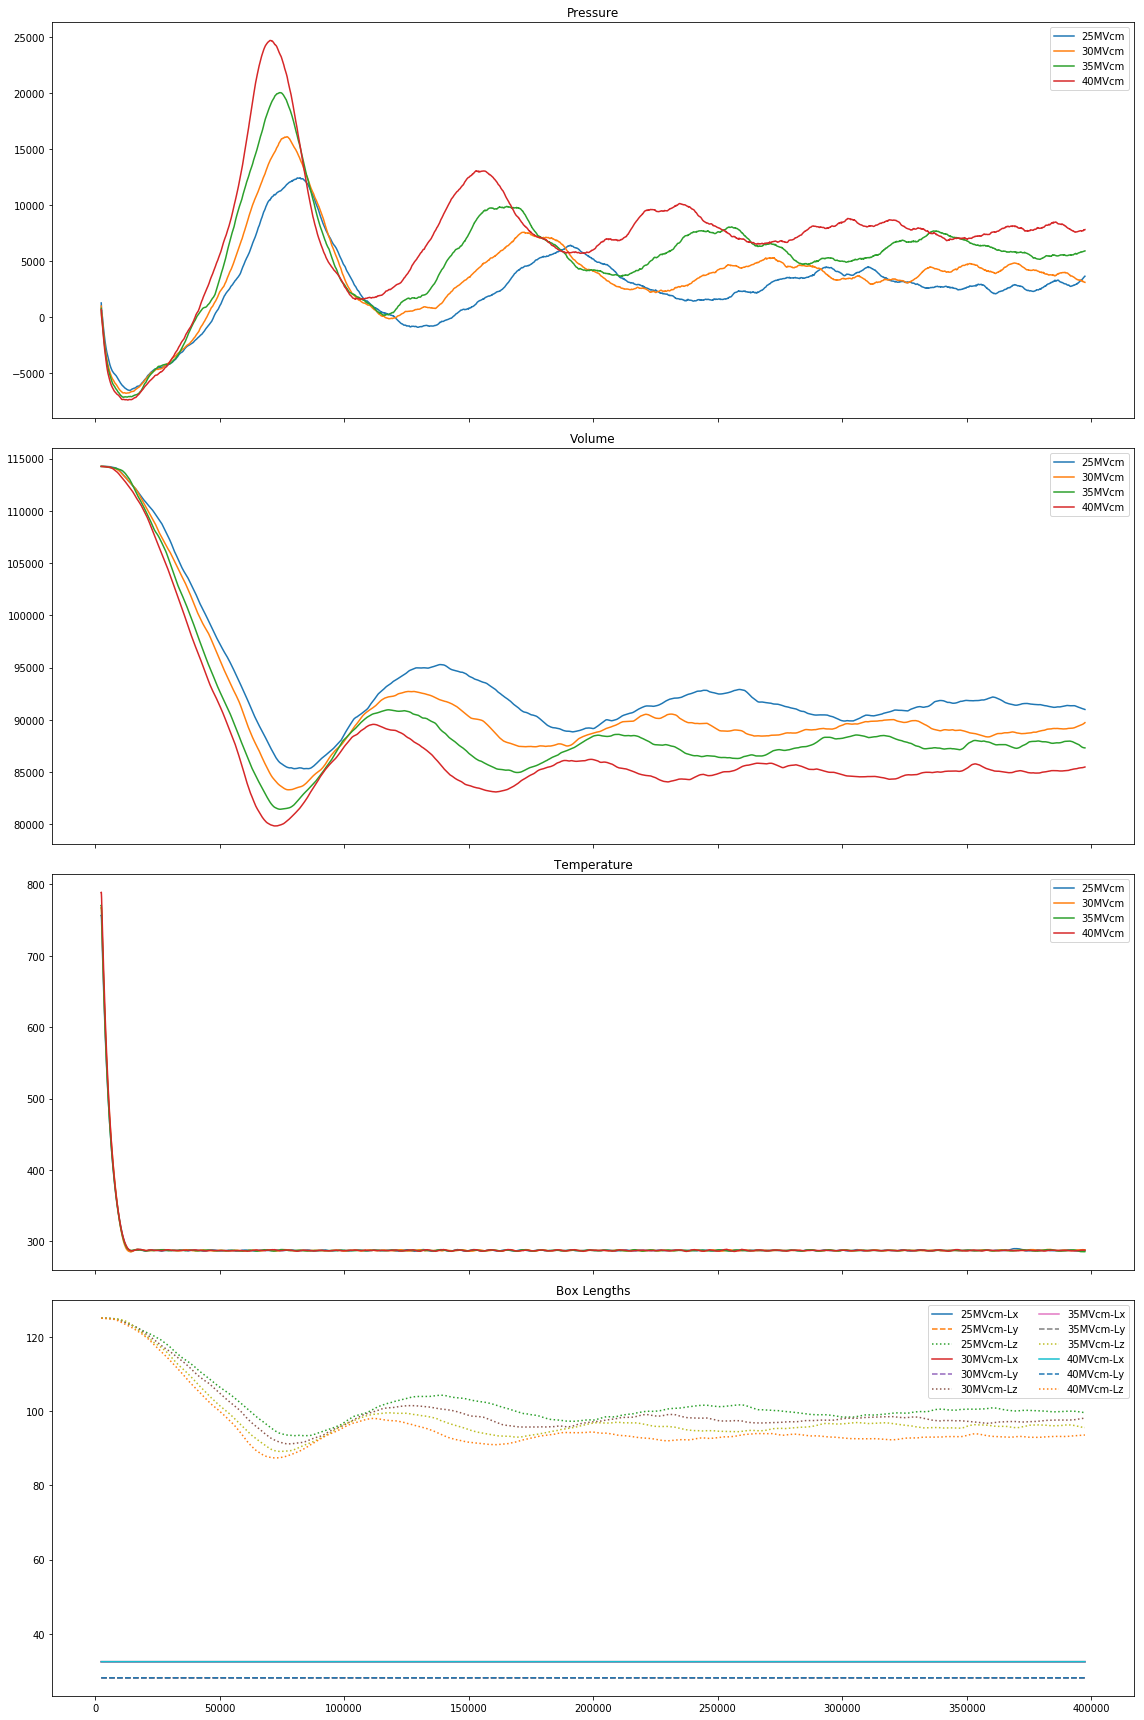

In [5]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(16, 24))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x[-6:] for x in Fe_aq_names]):
    ax1.plot(df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.temp.rolling(5000, center=True).mean(), label = name)
    
    ax4.plot(df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')
    
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=2)
f.tight_layout()
plt.show()

## Collate Prior Data

In [6]:
sim_list = {'trajectory': traj_lists, 'log_df': log_dfs, 'names': [x[-6:] for x in Fe_aq_names], 'bonds_list': bonds_list}

## Location of Atoms

In [12]:
# total run time = 400000
# positions_z = []
# for traj in sim_list['trajectory']:
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in range(0, len(traj), 100)]))
# Savinng binary somewhere
#     np.save(file='Fe_aq_imm_pos_z', arr=sim_list['positions_z'])
# Loading binary
positions_z = np.load('Fe_aq_imm_pos_z.npy')
sim_list['positions_z']=positions_z
sim_list['symbols']=np.array(sim_list['trajectory'][0][0].symbols)

## Saving Binary Somewhere

## Visualization

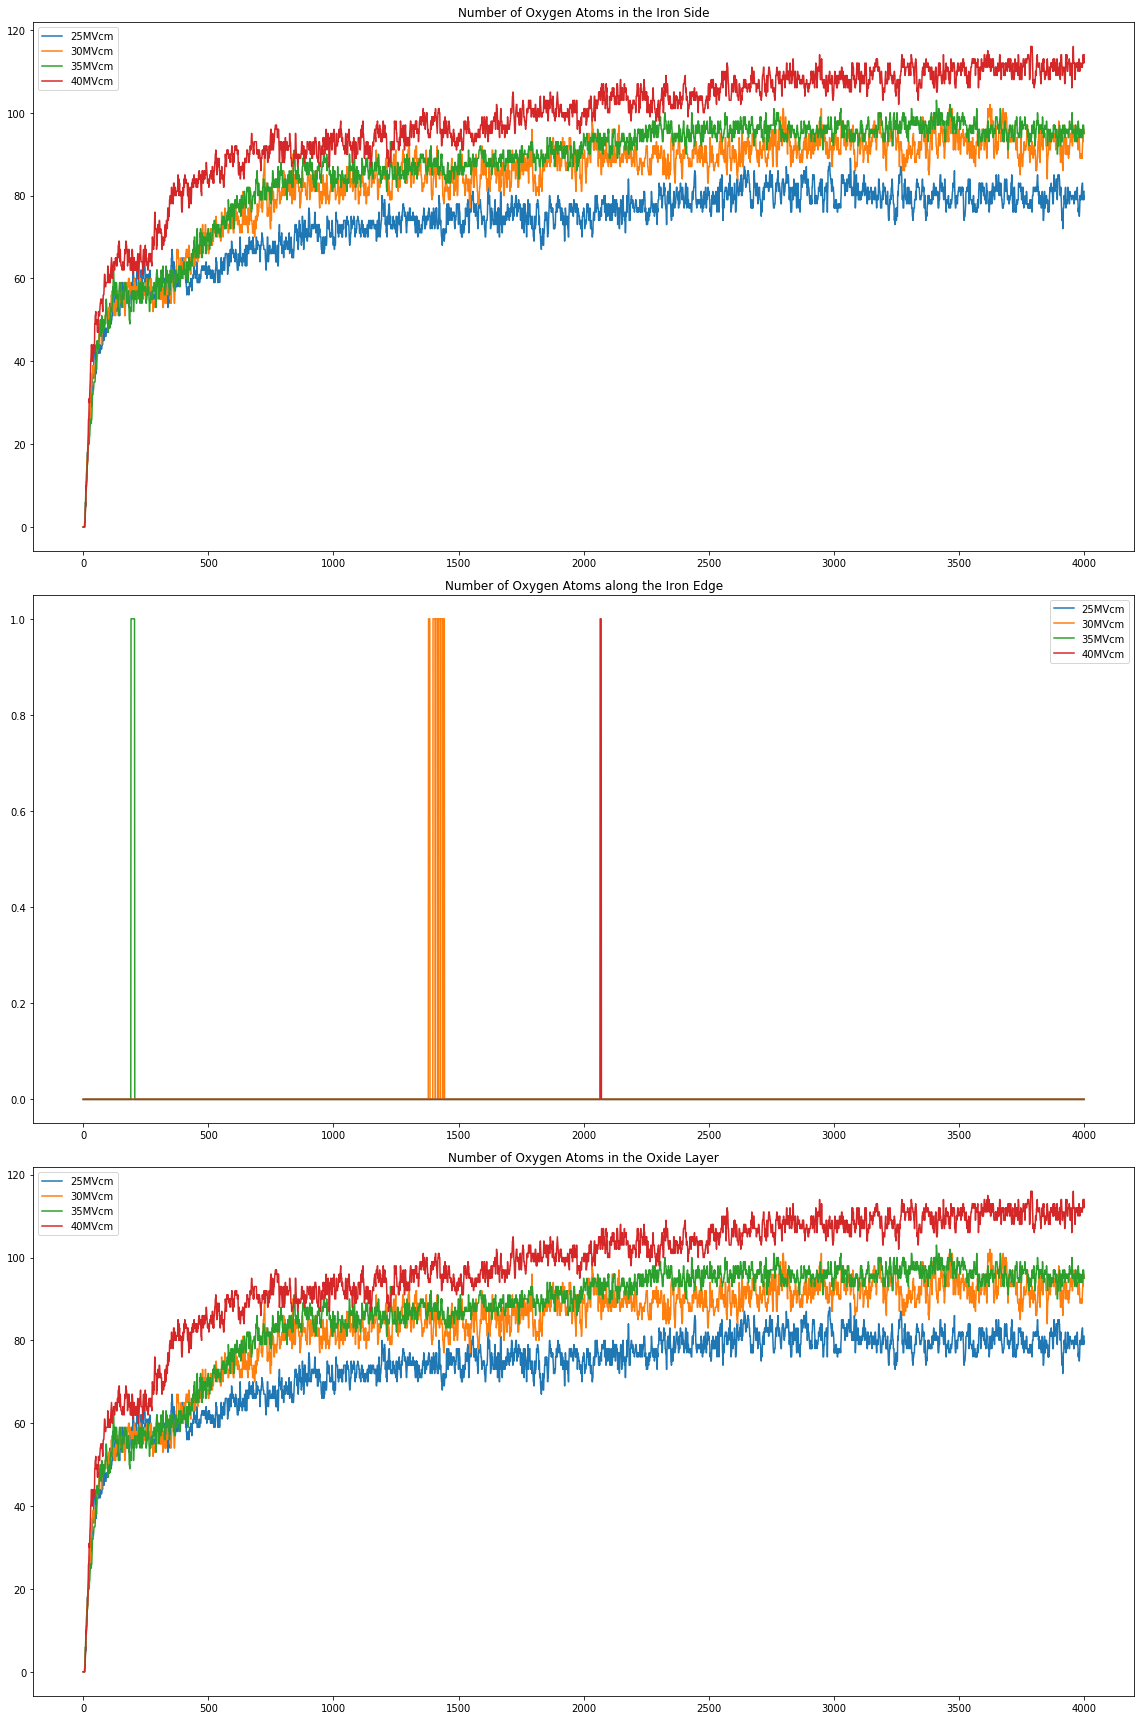

In [18]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc_upper = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], upper_cut_off, axis = 0)
    Fe_perc_lower = np.percentile(pos_z.T[sim_list['symbols']=='Fe'], lower_cut_off, axis = 0)
    
    O_below_upper = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc_upper)])
    O_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc_lower)])
    O_middle = O_below_upper - O_below_lower
    
    ax1.plot(O_below_upper, label = name)
    ax2.plot(O_below_lower, label = name)
    ax3.plot(O_middle, label = name)

ax1.set_title("Number of Oxygen Atoms in the Iron Side")
ax2.set_title("Number of Oxygen Atoms along the Iron Edge")
ax3.set_title("Number of Oxygen Atoms in the Oxide Layer")

ax1.legend()
ax2.legend()
ax3.legend()
f.tight_layout()
plt.show()

## Charge of Various Species

In [20]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=0.5))
sm.set_array([])

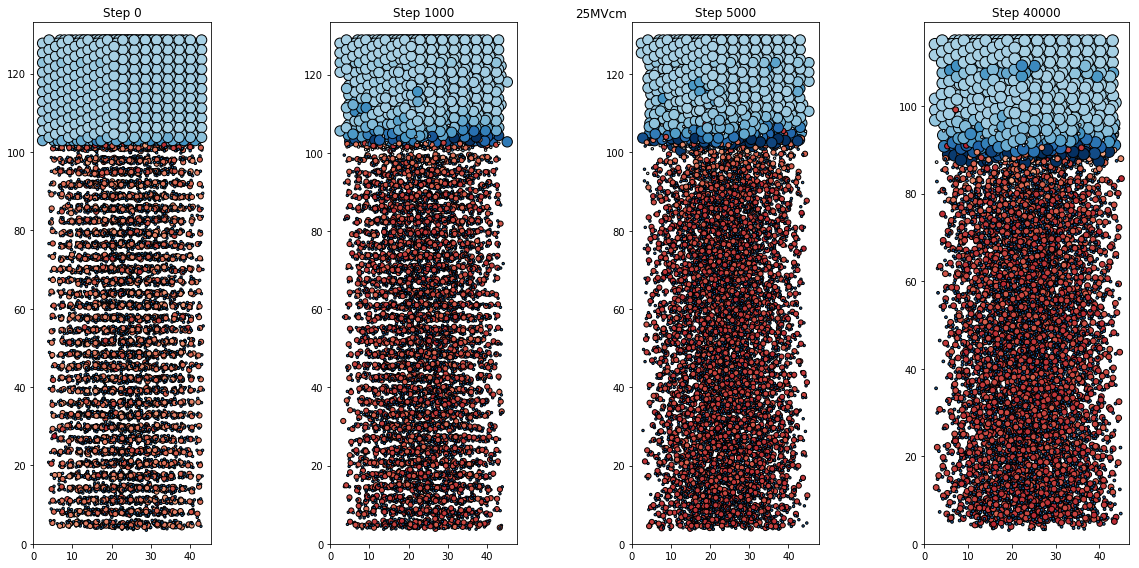

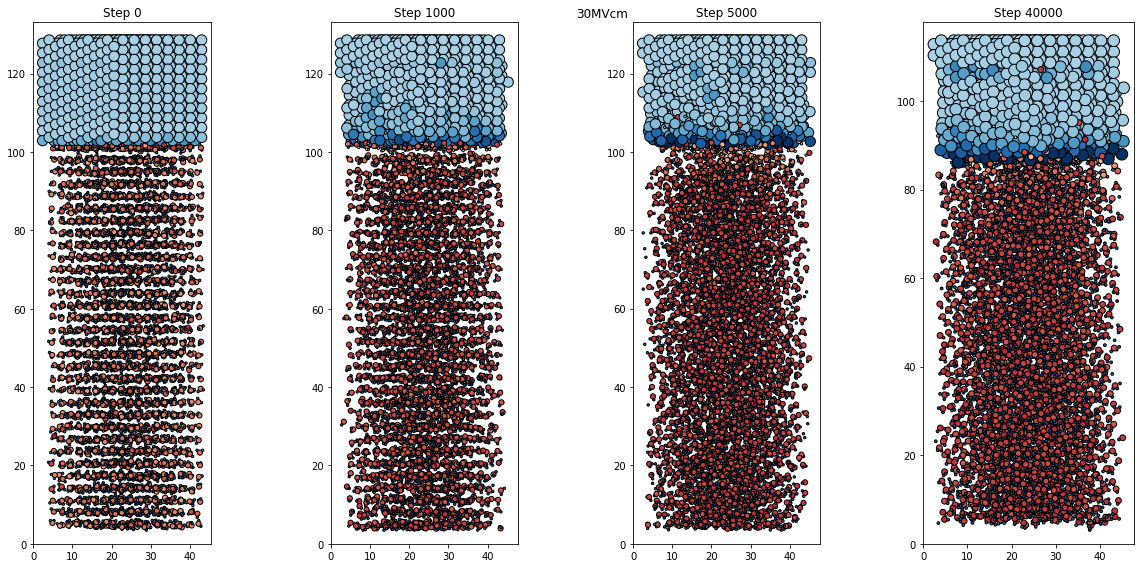

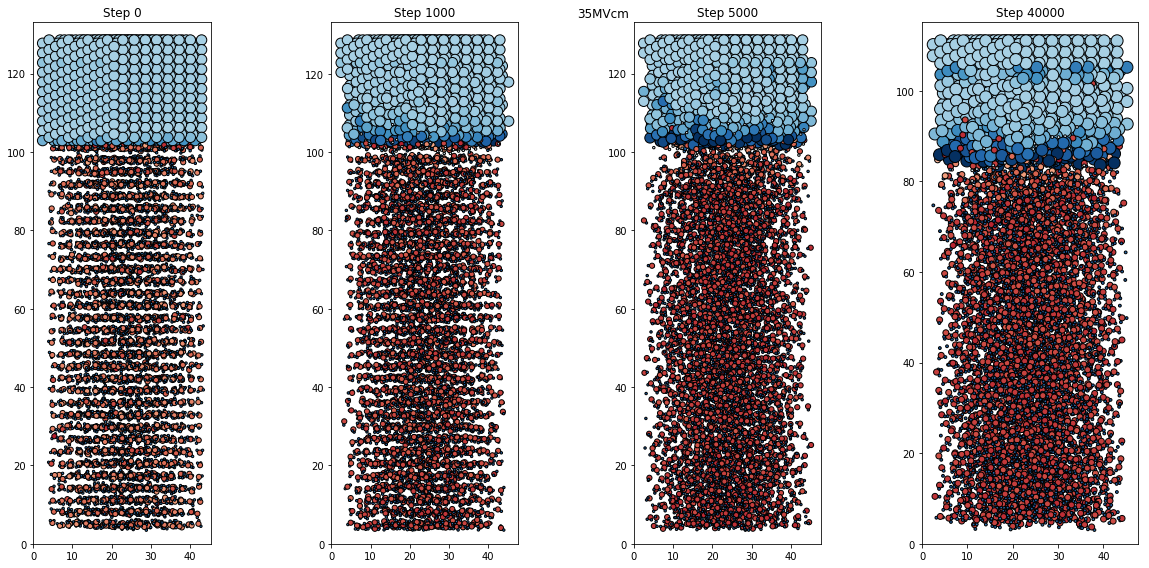

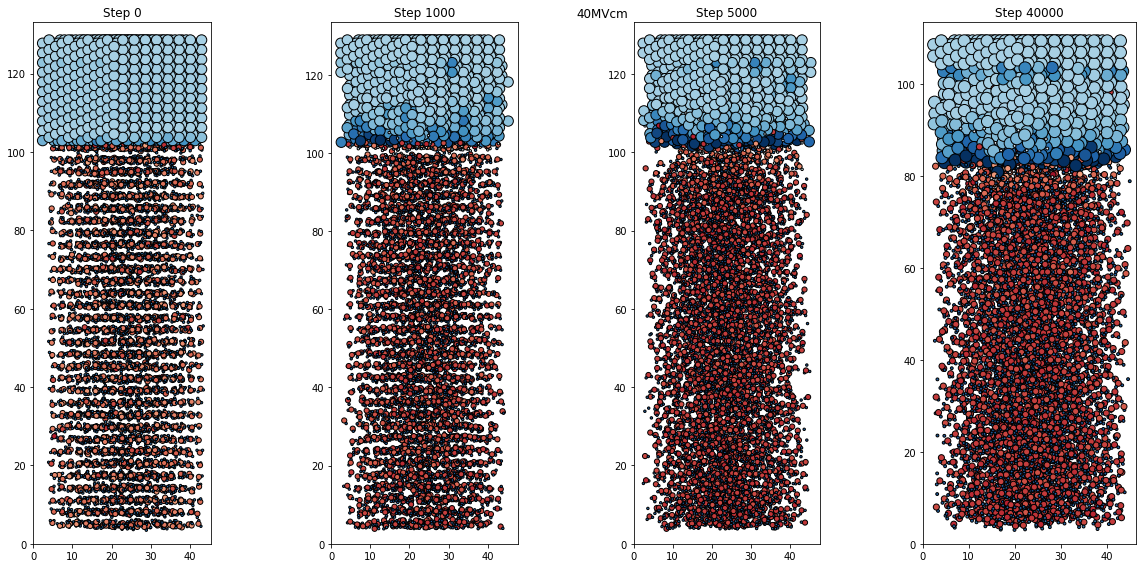

In [24]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 1000, 5000, 40000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.95)

plt.show()

## Backup Animation Production and Saving

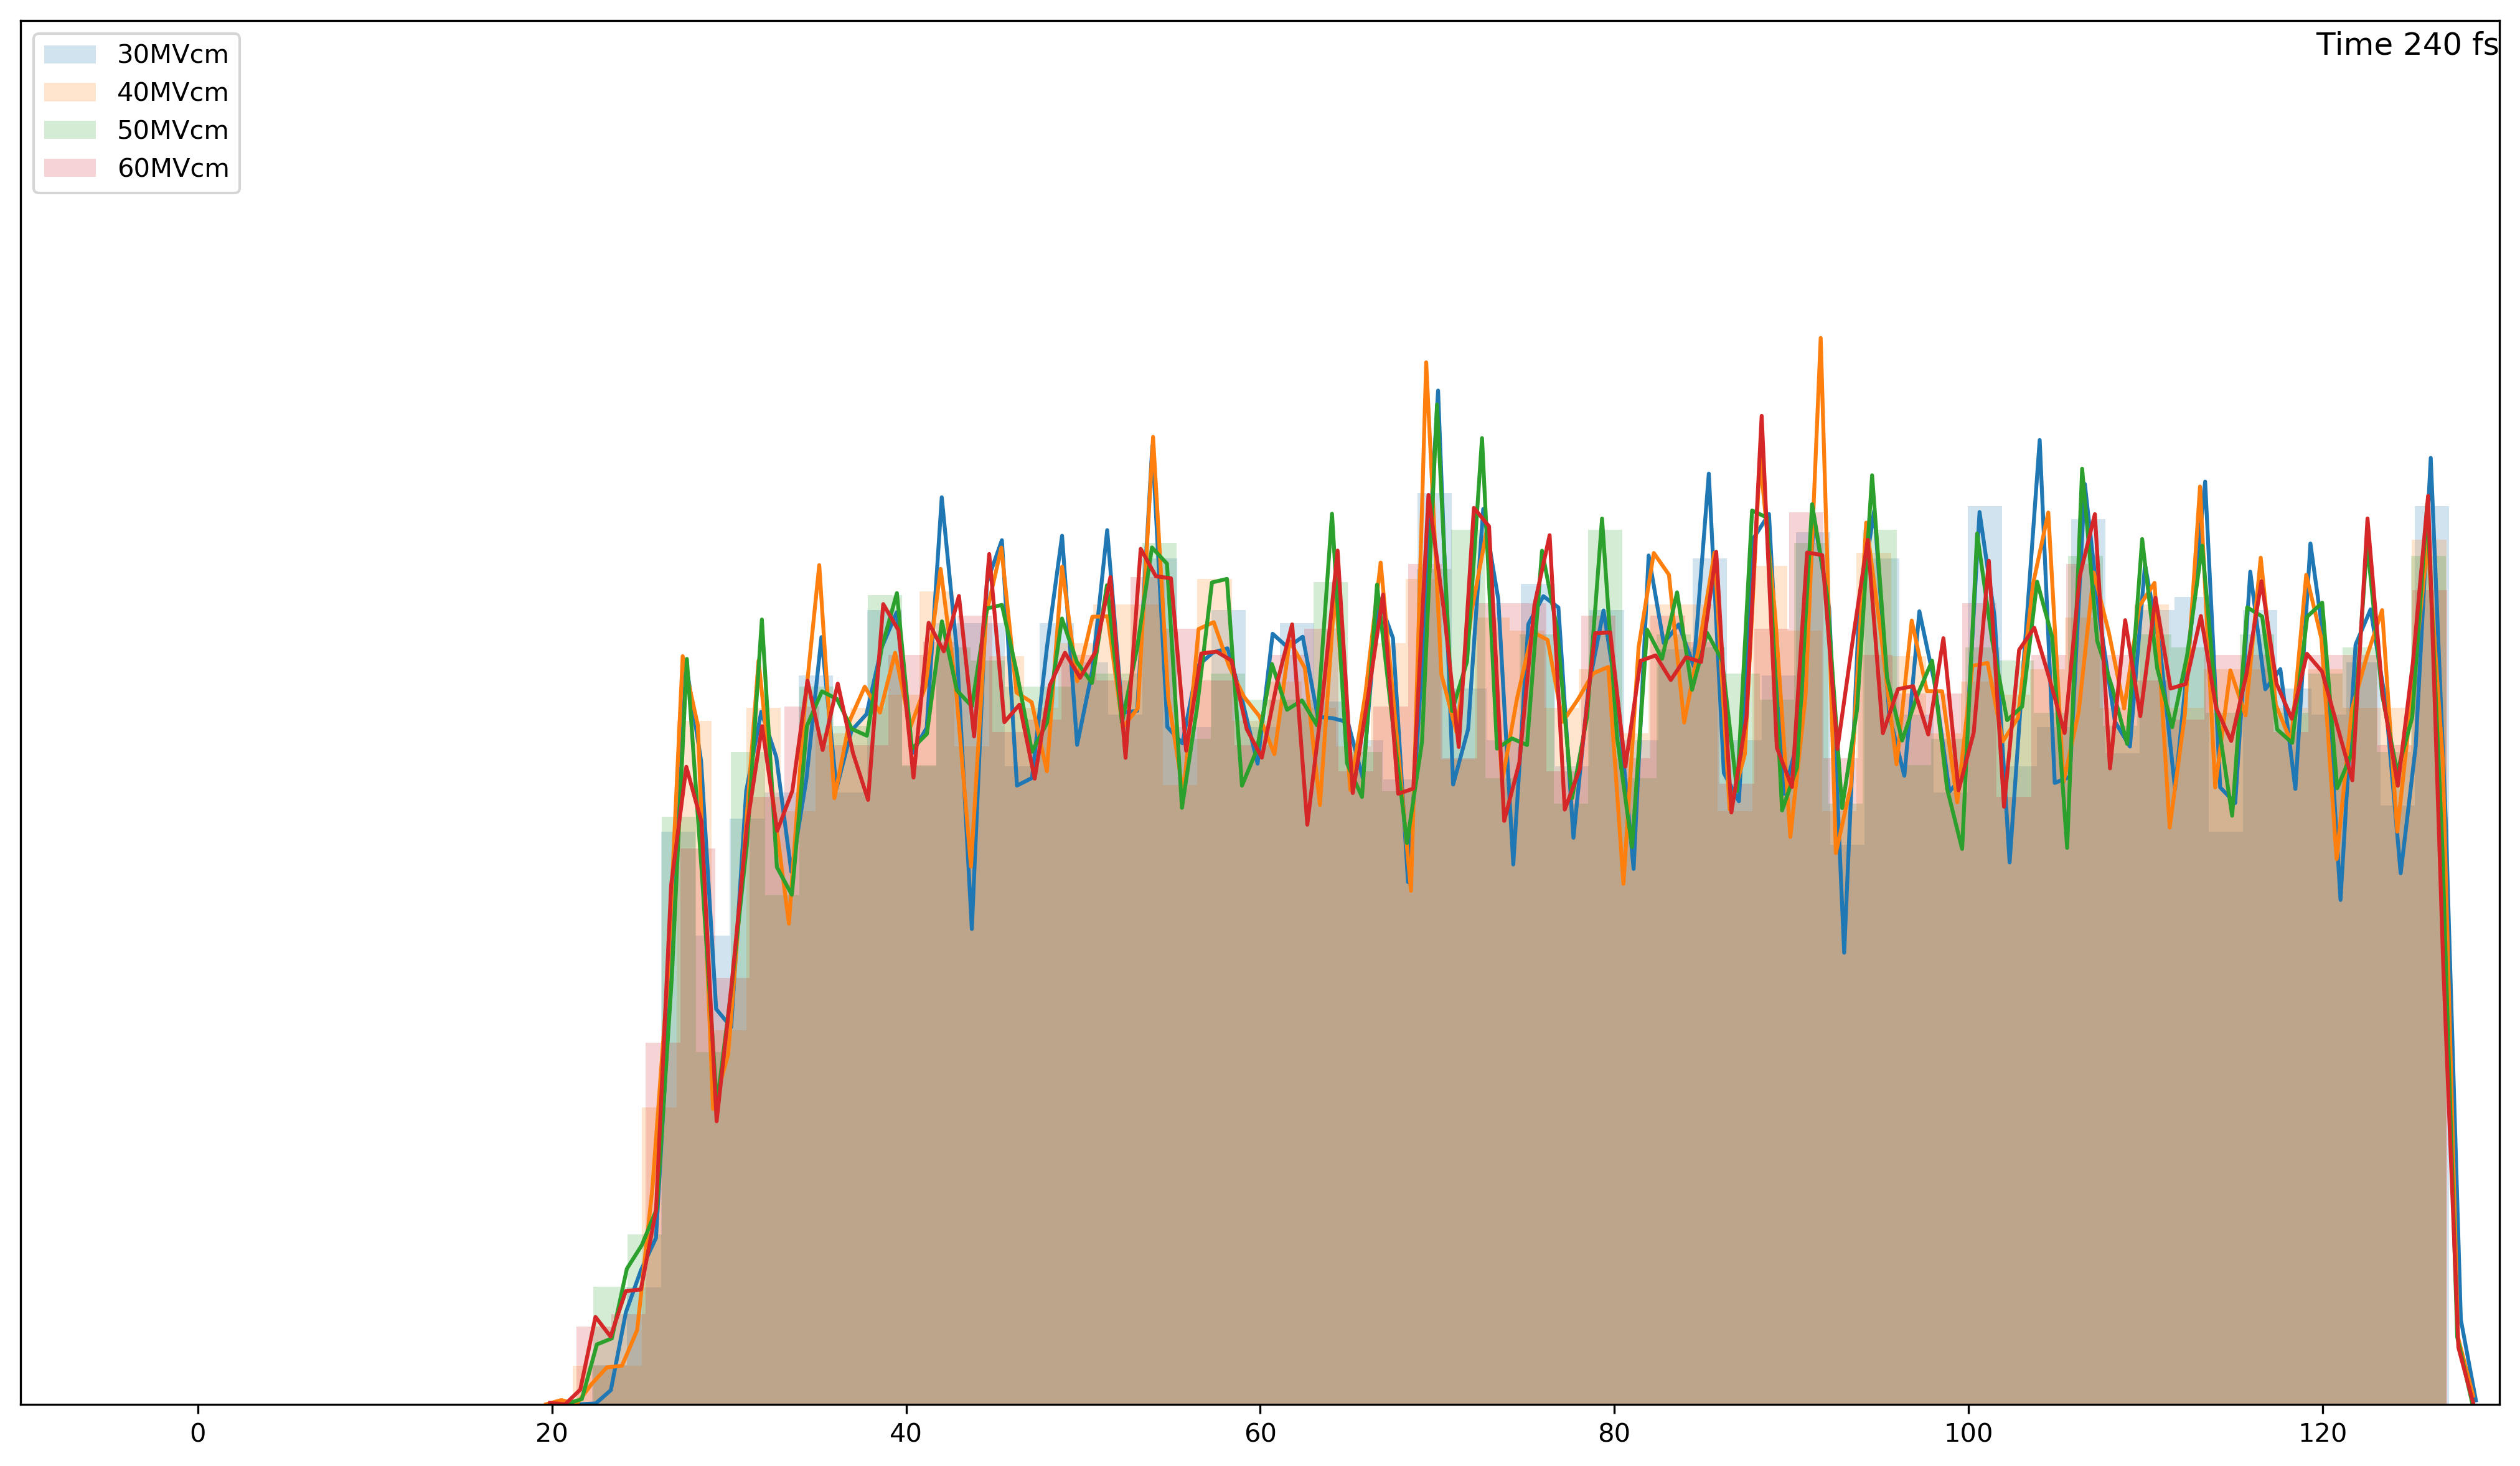

In [125]:
import subprocess

def testSubprocess(outf='testSubprocess.mp4', nframes=1):

    #set up the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    fig.set_dpi(300)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    
    # First frame
    ax.tick_params(labelleft=False, left=False)
    sns.kdeplot([], ax = ax)
    ax.set_xlim(-10, 130)
    ax.set_ylim(0, 0.019)

    def update(num):
            ax.clear()
            sns.distplot(sim_list['O_pos_z'][0][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][0])
            sns.distplot(sim_list['O_pos_z'][1][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][1])
            sns.distplot(sim_list['O_pos_z'][2][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][2])
            sns.distplot(sim_list['O_pos_z'][3][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][3])
            ax.set_title('Time {} fs'.format(num*10), loc='right', pad=-13)
            ax.set_xlim(-10, 130)
            ax.set_ylim(0, 0.019)
            ax.legend(loc=2)

    # Open an ffmpeg process
    cmdstring = ('/local/yiming/miniconda3/bin/ffmpeg', 
                 '-y', '-r', '25', # overwrite
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-crf', '20',
                 '-vcodec', 'libx264', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

testSubprocess(outf='Fe_H2O_efield.mp4', nframes=len(sim_list['O_pos_z'][0]))

## Pair Distribution Function

Pair distribution function of Fe-O 

## Temperature Difference